https://www.youtube.com/watch?v=3RNKb-ouAlI
# ML T-Generation Занятие 4: Классификация.
# Логрегрессия. KNN. Метрики.

Автор: Гаркавый Андрей (andrewgarkavyy@gmail.com)


## 0. План

1. Логистическая регрессия: теория

2. Логистическая регрессия: практика 

3. Сравнение с KNN

3. Precision/Recall

4. ROC-AUC

5. Небинарная классификация

## 1. Логистическая регрессия: теория
(в названии регрессия, но на самом деле это алгоритм классификации)


Рассмотрим **задачу классификации**. Для простоты рассматрим бинарную классификацию: для каждого примера в обучающей выборке указан его класс: 0 или 1.

Нам нужно по признакам научиться восстанавливать класс.

Мы уже умеем предсказывать числа (решать задачу регрессии) с помощью модели Линейной регрессии. Самое простое - использовать её для предсказания классов? А именно, будем просто предсказывать эти 0 и 1.

Тут даже понятно, как решать по предсказанному числу, какой это класс - если больше 0.5, то класс 1, иначе класс 0.

Этот подход работает, но он несколько противоестественный: предположим, наша модель предсказала для объекта класса 1 значение 2. За такое предсказание она получит такой же штраф, как за предсказание 0: $(2-1)^2 = (0-1)^2$.

Давайте попробуем придумать более естественную функцию потерь. Естественно считать, что чем больше предсказание нашей модели, тем сильнее она уверена, что объект принадлежит классу 1. Давайте попробуем интерпретировать предсказание модели как вероятность того, что объект принадлежит классу 1.

Модель (теоретически) может выдавать значения от минус до плюс бесконечности, значит нам нужно научиться превращать интервал $(-\infty, \infty)$ в интервал $(0, 1)$. Такие функции называют сигмоидами -- потому что они напоминают внешне букву s. Наиболее стандартная такая функция называется логистической функцией и выглядит так:
$$
 \sigma(x) = \frac{1}{1 + e^{-x}}
$$

In [104]:
%matplotlib inline
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd

In [2]:
# сигмоидная функция

def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

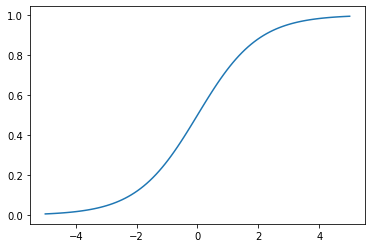

In [3]:
x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x))

Итак, можно считать, что если наша модель предсказывает для объекта $x$ число $f(x)$ это означает, что $p_x$ = $\sigma(f(x))$ - вероятность того, что объект принадлежит к классу 1.

Для данного примера класса 1 вероятность того, что наша модель угадала правльно равна $p_x$, для примера класса 0 эта вероятность равна $1-p_x$. 

Давайте посчитаем вероятность того, что наша модель "угадает" значение всех элементов:

$$\prod_{x \in 1} p_x \prod_{x \in 0} (1-p_x)$$

Мы хотим максимизировать эту вероятность.

Работать с произведением неудобно, поэтому возьмем логарифм:

$$\sum_{x \in 1} \ln(p_x)  + \sum_{x \in 0} \ln(1-p_x)$$

Из этого бы получилась отличная функция потерь, вот только функцию потерь мы хотим минимизировать, а эту функцию нужно максимизировать для лучшего результата. Поэтому умножим её на минус один.

$$Logloss = -\sum_{x \in 1} \ln(p_x)  - \sum_{x \in 0} \ln(1-p_x)$$

Эта функция потерь называется Logloss. Оказывается, что её довольно просто оптимизировать.

Описанный нами алгоритм называется **Логистическая регрессия**. Это алгоритм бинарной классификации (а не регрессии, пусть название вас не путает):

1) алгоритм предсказывает $f(x)$ по модели линейной регрессии ($f(x) = a_0 + a_1 x_1 + \ldots a_n x_n$)

2) от каждого значения считается сигмоида для предсказания вероятности ($p_x = \sigma(f(x)) = \frac{1}{1 + e^{f(x)}}$)

3) по этим вероятностям считается Logloss ($Logloss = -\sum_{x \in 1} \ln(p_x)  - \sum_{x \in 0} \ln(1-p_x)$)

4) параметры для модели подбираются так, чтобы именно этот логлосс и был минимален

5) предсказание после этого делается так: если вероятность больше 0.5 (то есть f(x) > 0), то это класс 1, иначе это класс 0.

Можно также представить, что вы пытаетесь разделить точки двух разных цветов с помощью плоскости. Все, точки оказавшиеся в одном полупространстве, вы предсказываете как класс 0, а в другом - как класс 1.

# 2. Логистическая регрессия: практика

Как обычно, эта модель уже есть в библиотеке sklearn.

In [4]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression() 

Мы будем работать с датасетом, содержащим данные о порядка 18 тысячах звезд, некоторые из которых являются пульсарами.

In [5]:
data = pd.read_csv('pulsar_stars.csv')

X = data.drop(columns=['target_class']) # убираем столбец с целевой переменной
y = data['target_class']

In [6]:
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


Как обычно, разбиваем данные на тренировочную и тестовую части.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Обучение модели классификации происходит ровно так же, как и модели регрессии:

In [8]:
log_reg.fit(X_train, y_train)

LogisticRegression()

Обратите внимание на первый параметр $С$ - он отвечает за регуляризацию: меньшие значения $С$ соответствуют большим штрафам за "усложнение" модели.

Предсказание происходит тоже ровно так же: получаем целевую функцию (класс) по методу predict.

In [9]:
y_pred = log_reg.predict(X_test)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

Но в отличие от регрессии у моделей классификации часто есть еще и возможность предсказать вероятность принадлежности классу:

In [10]:
y_pred_proba = log_reg.predict_proba(X_test)
y_pred_proba

array([[0.99380714, 0.00619286],
       [0.30027636, 0.69972364],
       [0.98309977, 0.01690023],
       ...,
       [0.9980718 , 0.0019282 ],
       [0.99352395, 0.00647605],
       [0.97040427, 0.02959573]])

# 3. Сравнение с KNN

Как понять, хороший ли получился результат? Самое простое - сделать как в регрессии, сравнить используемую метрику на нашей модели и на какой-нибудь другой. Давайте возьмем три модели:

1) Предсказать всем 0 (все равно звезда почти всегда не пульсар)

2) Лог. регрессия

3) KNN

In [11]:
from collections import Counter
Counter(y_train)

Counter({0: 11375, 1: 1153})

Оказывается, звезда в 10 раз чаще не пульсар, чем пульсар (по крайней мере в нашем датасете).

In [12]:
y_pred_const = np.zeros(len(X_test)) 
y_pred_proba_const = y_pred_const
y_pred_proba_const

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
y_pred_log_reg = log_reg.predict(X_test)
y_pred_proba_log_reg = log_reg.predict_proba(X_test)[:, 1]  # оставили только второй столбец
y_pred_proba_log_reg

array([0.00619286, 0.69972364, 0.01690023, ..., 0.0019282 , 0.00647605,
       0.02959573])

Осталось обучить модель KNN. Вы уже ее писали ее на первом занятии, но давайте вспомним, что это за алгоритм классификации.

**Метод K ближайших соседей (K Nearest Neighbors)** заключается в том, что мы рассматриваем каждый объект как точку в $n$-мерном пространстве, где $n$ - это число признаков. Тогда чтобы предсказать класс какой-нибудь новой точки, нам нужно просто найти $K$ ближайших к ней объектов в тренировочной части и выбрать самый популярный класс среди них.

Естественно, эта модель тоже уже написана в sklearn.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5) # выберем K=5 например
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [15]:
y_pred_knn = knn.predict(X_test)
y_pred_proba_knn = knn.predict_proba(X_test)[:, 1]  # оставили только второй столбец
y_pred_proba_knn[:10]

array([0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. ])

Этот алгоритм не заточен под предсказание вероятности принадлежности к классу, и делает это очень наивно и грубо: если среди $K$ соседей ровно $T$ принадлежат классу 1, то вероятность принадлежности классу 1 равна $\frac{T}{K}$.

Теперь осталось сравнить наши предсказанные результаты. Например, раз мы учили лог. регрессию на logloss, давайте сравним его (помните, для регрессии же мы сравнивали MSE).

**Обязательное задание 1**: реализуйте logloss.

In [16]:
# Реализуйте функцию
# Как обычно, чем короче, тем лучше

def logloss(y_real, y_pred_proba):
    return np.sum(-np.log(y_pred_proba[index]) for index, elem in enumerate(y_real) if elem == 1) + np.sum(-np.log((1 - y_pred_proba[index])) for index, elem in enumerate(y_real) if elem == 0)

logloss([1, 1, 0, 1], [0.5, 0.5, 0.4, 0.4])

2.8134107167600364

In [17]:
# Тест:
print('Logloss =', logloss(np.array([0, 1, 0, 1, 0]), np.array([0.2, 0.8, 0.4, 0.6, 0.6])))
print('Real answer =', -(np.log(0.8) + np.log(0.8) + np.log(0.6) + np.log(0.6) + np.log(0.4)))


Logloss = 2.3842290820345555
Real answer = 2.384229082034556


Давайте посмотрим, чему равен лог лосс на разных моделях.

In [18]:
logloss(y_test, y_pred_proba_const)

inf

Наша модель "все вероятности равны 0" не работает: если мы угадали все классы, то мы действительно получаем логлосс 0. Но если мы хотя бы раз ошиблись, то мы получим минус логарифм от 0, то есть бесконечность. Предсказывать вероятность в логлоссе как прямо 0 никогда нельзя.

In [19]:
logloss(y_test, y_pred_proba_log_reg)

414.55443397088015

In [20]:
logloss(y_test, y_pred_proba_knn)

inf

С KNN получилась такая же проблема: слишком много вероятностей, равных 0.

Как мы видим, Logloss так себе подходит для сравнения результатов классификации - у наивных моделей там часто возникают бесконечности, да и само число ничего конкретного не значит. В MSE мы хотя бы примерно понимали, что такое средний квадрат отклонений, а тут это абсолютно не говорящее ни о чем число.

Давайте лучше посчитаем **точность** - accuracy. То есть просто **долю объектов с правильно предсказанным классом**.

(вообще называеть ее "точность" - плохая идея, потому что у другой метрики, которую мы сегодня рассмотрим (precision) на русский ровно тот же перевод)

**Обязательное задание 2:** реализуйте функцию accuracy.

In [21]:
# Реализуйте функцию
# Как обычно, чем короче, тем лучше

def accuracy(y_real, y_pred):
    return np.sum(1 for index, elem in enumerate(y_real) if elem == y_pred[index]) / len(y_real)


In [22]:
# Тест:
print('Accuracy =', accuracy(np.array([0, 1, 0, 1, 0]), np.array([0, 0, 0, 1, 1])))
print('Real answer =', 0.6)

Accuracy = 0.6
Real answer = 0.6


Давайте посмотрим, чему равна accuracy на разных моделях.

In [23]:
accuracy(y_test, y_pred_const)

0.9094972067039107

In [24]:
accuracy(y_test, y_pred_log_reg)

0.9791433891992551

In [25]:
accuracy(y_test, y_pred_knn)

0.9733705772811918

Итак, мы явно видим, что точность константного предсказания (все звезды - не пульсары) - это уже 90%. Действительно, в тестовой части тоже каждая только примерно 10-я звезда является пульсаром.

Причем точности и Лог. регрессии, и KNN - значительно выше, это чуть больше 97%. На конкретно моем разбиении на train и test получилось, что accuracy у лог. регрессии все-таки лучше, но пока неясно, это погрешность и разницы особое нет, или все-таки есть значительнон преимущество.

Здесь сразу видна большая проблема: из-за несбалансированности классов (9 к 1) accuracy наивного предсказания легко набирает сразу 90%. Очень тяжело сравнивать модели по метрике, которая у всех нормальных моделей находится на маленьком отрезке $[0.9, 1.0]$. А представьте, что пульсаров было бы еще меньше: один из сотни звезд. А такое в жизни бывает очень часто - например в рекламе вам нужно понять, сделает ли юзер клик по этому баннеру, и этих кликов по баннеру в данных встречается очень и очень мало, обычно все-таки клика нет. Поэтому модель "всегда нет клика" будет сразу набирать 99% accuracy.

Для таких дико несбалансированных данных нужны какие-то другие, более говорящие метрики.

# 4. Precision / Recall

Чтобы обойти эту проблему часто рассматривают две другие метрики: **precision** (точность) и **recall** (полнота). Пусть у нас все еще бинарная классификация, и класса 0 очень много, а вот класса 1 - поменьше.

Точность -- доля объектов класса 1 среди всех объектов, которые наш классификатор отнес к классу 1.

Полнота -- доля объектов класса 1, которые наш классификатор определил правильно среди всех объектов класса 1:

**Обязательное задание 3:** реализовать две эти функции.

In [26]:
# Реализуйте функцию
# Как обычно, чем короче, тем лучше

def precision(y_real, y_pred):
    y_real = list(y_real)
    y_pred = list(y_pred)
    if np.sum(elem for elem in y_pred if elem == 1) == 0:
        return np.nan
    return np.sum(elem for index, elem in enumerate(y_pred) if elem == 1 and y_real[index] == 1) / np.sum(elem for elem in y_pred if elem == 1)

def recall(y_real, y_pred):
    y_real = list(y_real)
    y_pred = list(y_pred)
    if np.sum(elem for elem in y_real if elem == 1) == 0:
        return np.nan
    return np.sum(elem for index, elem in enumerate(y_pred) if elem == 1 and y_real[index] == 1) / np.sum(elem for elem in y_real if elem == 1)


In [27]:
print(precision(y_test, y_pred_const))
print(recall(y_test, y_pred_const))

nan
0.0


In [28]:
print(precision(y_test, y_pred_log_reg))
print(recall(y_test, y_pred_log_reg))

0.9389671361502347
0.823045267489712


In [29]:
print(precision(y_test, y_pred_knn))
print(recall(y_test, y_pred_knn))

0.9054373522458629
0.7880658436213992


Какие мы получили результаты? 

1) Константное предсказание "всегда говори 0" получает nan точность (это доля пульсаров среди предсказанных пульсаров, а мы ни один решили не предсказывать) и 0 полноту (это доля пульсаров, которые мы нашли, а мы ничего не нашли).

2) Среди предсказанных с помощью KNN и Лог. регрессии пульсаров 90%-94% звезд действительно являются пульсарами.

3) А вот среди всех пульсаров наши модели нашли только 78%-80% пульсаров.

4) В целом получается, что модели предсказывают пульсары скорее точно, но при этом много еще не находят (точность больше полноты).

Часто для того, чтобы учесть несбалансированность нашего множества, мы можем задать разный вес для разных классов. 
Например, у Лог. регрессии есть параметр class_weight, который принимает словарь, сопоставляющий каждому классу его вес.

При этос вес участвует в Логлоссе - каждое слагаемое с реальным классом 1 просто умножается на вес класса 1, а слагаемое с реальным классом 0 просто умножается на вес класса 0.

По сути эти веса значат то, насколько важнее предсказать хорошо класс 0 или класс 1.

$$Logloss = -w_1 \sum_{x \in 1} \ln(p_x)  -w_0 \sum_{x \in 0} \ln(1-p_x)$$

В изначальных данных у нас почти все звезды были пульсарами (класса 0), и их качество предсказания было гораздо важнее, давайте сбалансируем веса (так половина веса будет приходить из обычных звезд и половина веса из пульсаров).

In [46]:
log_reg_w = LogisticRegression(class_weight = {0: 1, 1: 10})

In [47]:
log_reg_w.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 10})

In [48]:
y_pred_w = log_reg_w.predict(X_test)
y_pred_proba_w = log_reg_w.predict_proba(X_test)[:, 1]

In [49]:
print(precision(y_test, y_pred_w))
print(recall(y_test, y_pred_w))

0.7437603993344426
0.9197530864197531


Точность классификатора заметно упала -- он стал чаще говорить "1" (так как ошибиться с непульсаром теперь не так страшно), но зато заметно возросла полнота. Хорошо это или плохо -- зависит от того, как мы собираемся использовать наш классификатор.

Если для нас очень важно не пропустить ни одного пульсара (а если мы какую-то звезду тоже назовем пульсаром по ошибке, то не очень страшно) нам нужно растить полноту -- это возможно, например, если потом на выбранные звезды посмотрят в радиотелескоп и уточнят предсказание.

А может быть, что для нас важно не назвать пульсаром звезду, которая им не является (например, ко всем потенциальным пульсарам мы отправим дорогой исследовательский зонд -- не страшно пропустить какие-то, но очень обидно отправить зонд к не-пульсару).


Для полноты картины введем еще два определения:
    - ошибка первого рода (Type I error, false positive) - ситуация, когда наша модель отнесла объект класса 0 к классу 1
    - ошибка второго рода (Type II error, false negative) - ситуация, когда наша модель отнесла объект класса 1 к классу 0
    
Аналогично правильные предсказания можно разделить на true positives и true negatives

![Таблица](table.jpg)

Как запомнить какая ошибка что: в сказке про мальчика, который кричал "Волк!" сначала описывается ошибка первого рода, а потом - второго.

![Ошибки](errors.jpg)

**Обязательно задание 4:** запишите accuracy, precision и recall в терминах количества ошибок первого и второго рода (FP и FN) и количества правильных предсказаний (TP, TN).

Accuracy = (TP + TN) / (TP + TN + FP + FN)

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

**Обязательное задание 5:** постройте график зависимости precision и recall от соотношения весов в графе в логистической регрессии.

Пусть вес класса 0 будет всегда равен 1, переберите чему равен вес класса 1.

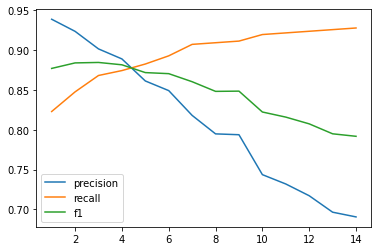

In [59]:
X_data = np.arange(1, 15);
precision_data = []
recall_data = []
f1_data = []
for weight in X_data:
    log_reg_w = LogisticRegression(class_weight = {0: 1, 1: weight})
    log_reg_w.fit(X_train, y_train)
    y_pred_w = log_reg_w.predict(X_test)
    precision_data.append(precision(y_test, y_pred_w))
    recall_data.append(recall(y_test, y_pred_w))
    f1_data.append((2 * precision_data[-1] * recall_data[-1]) / (precision_data[-1] + recall_data[-1]))

plt.plot(X_data, precision_data)
plt.plot(X_data, recall_data)
plt.plot(X_data, f1_data)
plt.legend(['precision', 'recall', 'f1'])

Существует метрика, объединяющая точность и полноту - их среднее гармоническое. Эта метрика называется $F_1$-мерой:

$$ F_1 = \frac{2* precision*recall}{precision+recall}$$

**Обязательное задание 6:** добавьте на график еще и f1-меру.

*** Уже добавил *** 

# 5. ROC-AUC

Продолжим изучать метрики бинарной классификации. Представим, что мы предсказали пульсары - но изучать их надо в каком-то порядке. В порядке уменьшения вероятности, что они пульсары.

Надо как-то научить мерить, **насколько хорошо мы предсказали вероятности с точки зрения порядка**.

Давайте отсортируем все зведы по вероятности, что они пульсары. Если бы мы идеально предсказали пульсары, то сначала в этом списке идут исключительно не-пульсары, а потом исключительно пульсары.

В реальности, конечно, там будут ошибки.

In [60]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.00619286, 0.69972364, 0.01690023, ..., 0.0019282 , 0.00647605,
       0.02959573])

In [61]:
list(zip(X_test.index, y_pred_proba))[:5]

[(15985, 0.006192855966662673),
 (8188, 0.6997236361205579),
 (8157, 0.016900233431803618),
 (2589, 0.42517050674207146),
 (11909, 0.022945692508192096)]

In [62]:
sorted_by_proba = sorted(list(zip(X_test.index, y_pred_proba)), key=lambda x: x[1])
sorted_by_proba[:5]

[(14049, 2.6685737913293245e-08),
 (13504, 2.9583046834148258e-08),
 (16272, 5.008051800853937e-08),
 (9529, 5.181619770013153e-08),
 (7472, 6.313766000670209e-08)]

In [63]:
results = [y_test[id] for id, proba in sorted_by_proba]
print(results[:25])
print(results[1000:1025])
print(results[3000:3025])
print(results[5000:5025])
print(results[-25:])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]


Вот мы отсортировали по вероятности принадлежности классу 1 - и действительно, сначала долго идут объекты класса 0, потом в какой-то момент начинают появляться пульсары, потом их все больше, и в конце остаются исключительно они (ну почему-то кроме последнего в моем случае).

Датасайентисты очень любят рисовать ROС-кривую.

1.0

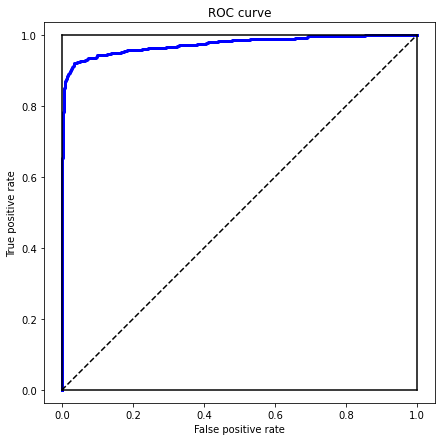

In [67]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(7, 7))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, 'b', linewidth=3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 0], [0, 1], 'k')
plt.plot([1, 1], [0, 1], 'k')
plt.plot([0, 1], [0, 0], 'k')
plt.plot([0, 1], [1, 1], 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.axis('equal')
plt.title('ROC curve')
plt.show()

У ROC-кривой в общем-то есть два определения.

1) Вот у нас есть отсортированный по вероятности массив объектов. Нам нужно решить, где его разрезать на две части - все левые мы предскажем как класс 0, а правые как класс 1.

Давайте для каждого возможного разреза просто посчитаемдве метрики и нарисуес график зависимости одной от другой:

$$False\space positive\space rate = \frac{FP}{FP + TN} = \frac{FP}{size(0)}$$
$$True\space positive\space rate = \frac{TP}{TP + FN} = \frac{TP}{size(1)}$$

False positive rate - это доля предсказанных пульсаров среди реальных не-пульсаров.

True positive rate - это доля предсказанных пульсаров среди реальных пульсаров.

2) Наша кривая начинается в точке $(0, 0)$ и заканчивается в точке $(1, 1)$ (действительно, если мы все считаем не-пульсарами, то FPR = 0, TPR = 0, иначе FPR = 1, TPR = 1.

Между ними она должна сделать несколько шагов вверх и вправо. Давайте просто идти слева направо по нашему и списку и каждый раз, когда попался объект класса 0, делать шаг вверх на $\frac{1}{size(0)}$, а когда встретился объект класса 1, делать шаг вправо на $\frac{1}{size(1)}$. Тогда мы в итоге обязательно придем из (0, 0) в (1, 1), и это получится ровно та же кривая.

Действительно, каждый раз мы на самом деле просто перемещаем один объект из класса 0 в класс 1. Если его реальный класс равен 0, то TPR не изменился, а FPR увеличился на $\frac{1}{size(0)}$. Если его реальный класс равен 1, то FPR не изменился, а TPR увеличился на $\frac{1}{size(1)}$. Так что это то же самое.

Кривая это хорошо, но нам бы хотелось числовую метрику, которая бы говорила, насколько хорош получившийся из вероятностей порядок. Для это обычно берут **площадь под этой кривой** (Areas Under Curve - AUC), её еще называют ROC-AUC.

Она не больше, чем 1, и чем выше и левее эта кривая, тем лучше.

Практически всегда ROC AUC > 0.5 (иначе это легко поправить - надо просто перевернть все вероятности).

ROC AUC позволяет глубоко оценивать качество предсказанных вероятностей. Accuracy, Precision и Recall работали только с самими предсказаниями классов, и никак вероятности не затрагивали.

In [68]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_proba)

0.9740131545687101

# 6. Небинарная классификация

Мы с вами рассматривали всё это время только задачу бинарной классификации, но что делать, когда классов болше, чем 2? На самом деле есть простой способ сводить любую классификацию к бинарной.

Методика называется **One vs The Rest**. Давайте просто рассмотрим каждый класс как независимую бинарную классификацию, и будем предсказывать вероятности того, что этот элемент лежит в этом классе, или не лежит.

Так про каждый класс мы получим вероятность, лежит ли в нем объект. Из них мы уже сможем выбрать лучший класс для этого объекта. А чтобы получить вероятности принадлежности каждому классу, эти числа еще нужно отнормировать, чтобы в сумме они давали 1.

Давайте, например, рассмотрим датасет с циферками.

In [69]:
from sklearn.datasets import load_digits
data = load_digits()
data.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [70]:
print(data['DESCR'])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [71]:
X = data['data']
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

Эти фичи - это на самом деле яркости пикселей вот такой картинки 8x8. Каждый пиксель - это число от 0 до 15.

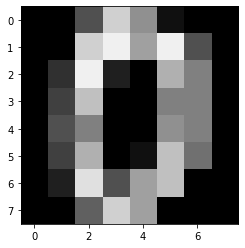

In [72]:
def draw_digit(features):
    plt.imshow(features.reshape(8, 8), cmap=plt.cm.gray, vmax=16, interpolation='nearest')

draw_digit(X[0])


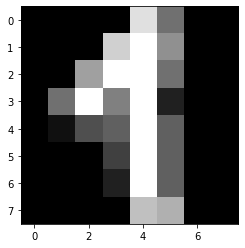

In [84]:
draw_digit(X[70])

In [85]:
y = data['target']
Counter(y)

Counter({0: 178,
         1: 182,
         2: 177,
         3: 183,
         4: 181,
         5: 182,
         6: 181,
         7: 179,
         8: 174,
         9: 180})

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

В логистической регрессии уже по умолчанию включен мод One vs The Rest и она работает для нескольких классов.

In [87]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [88]:
y_pred_log_reg = log_reg.predict(X_test)
y_pred_log_reg

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 3, 5, 6, 0, 9, 0, 0, 1, 0, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 5, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5,
       7, 5, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 5, 5, 6, 6, 0,
       6, 4, 3, 9, 3, 8, 7, 2, 9, 0, 6, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 2, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 8, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 1, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 9, 1, 4, 7, 6, 5, 8, 5,
       5, 1, 5, 2, 8, 8, 9, 9, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 9, 7,
       7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5,
       5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2,

predict_proba теперь возвращает массив с вероятностями каждого из 3 классов.

In [90]:
y_pred_proba_log_reg = log_reg.predict_proba(X_test)
y_pred_proba_log_reg

array([[1.85427060e-09, 2.91836917e-11, 1.27753939e-14, ...,
        4.48665294e-12, 5.28314346e-06, 5.37602657e-12],
       [1.75595181e-06, 8.08279730e-12, 1.29542082e-13, ...,
        5.53019381e-08, 4.77728415e-09, 9.96915028e-01],
       [1.06452617e-17, 1.53858169e-16, 1.01795760e-10, ...,
        4.65451877e-14, 3.01971332e-09, 7.16359927e-07],
       ...,
       [7.22906250e-04, 5.31658263e-05, 6.29678122e-05, ...,
        2.59689398e-03, 9.85923350e-01, 1.31688653e-03],
       [1.45401426e-08, 4.52786161e-11, 4.10157737e-03, ...,
        1.46344712e-08, 1.01485091e-05, 8.87941408e-06],
       [2.78177344e-10, 5.29329386e-14, 5.31309599e-15, ...,
        2.36125791e-15, 4.37807795e-12, 8.34253201e-08]])

А вот для KNN вообще нет разницы, два класса или больше: алгоритм работает ровно так же - выбирает самый популярный класс из $K$ соседей.

In [91]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [92]:
y_pred_knn = knn.predict(X_test)
y_pred_knn

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 9, 5, 6, 0, 9, 0, 0, 1, 0, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 9, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5,
       7, 9, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 3, 5, 6, 6, 0,
       6, 4, 3, 9, 3, 4, 7, 2, 9, 0, 4, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 5, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 8, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 5, 1, 4, 7, 6, 8, 8, 5,
       5, 1, 6, 2, 8, 8, 9, 5, 7, 6, 2, 2, 2, 3, 4, 8, 8, 3, 6, 0, 9, 7,
       7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 3, 6, 5, 9, 7, 3, 5,
       5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2,

In [93]:
y_pred_proba_knn = knn.predict_proba(X_test)
y_pred_proba_knn

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [94]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_log_reg))
print(accuracy_score(y_test, y_pred_knn))

0.9694444444444444
0.9861111111111112


Метрика Accuracy - одна из немногих, которая легко переносится с бинарной классификации на небинарную. Это все еще просто доля объектов с верно угаданным классами.

Как мы видим, обе известные нам модели работают на цифрах очень и очень круто, учитывая что там 10 сбалансированных классов, а они угадывают больше 96%.

Вот с другими метриками возникают проблемы - неочевидно как обобщить их на несколько классов. Обычно есть два способа это сделать.

- macro - это аналог One vs The Rest, метрика просто считается для каждого класса независимо, а потом усредняется

- micro - это более сложная вещь, здесь нужно рассмотреть каждую пару "объект, класс" как объекты, и как будто считать метрики на бинарной классификации в этой задаче

In [95]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [98]:
print(precision_score(y_test, y_pred_log_reg, average='macro'))
print(precision_score(y_test, y_pred_knn, average='macro'))

0.9708830464104297
0.9879206496042758


In [99]:
print(precision_score(y_test, y_pred_log_reg, average='micro'))
print(precision_score(y_test, y_pred_knn, average='micro'))

0.9694444444444444
0.9861111111111112


In [100]:
print(recall_score(y_test, y_pred_log_reg, average='macro'))
print(recall_score(y_test, y_pred_knn, average='macro'))

0.9721963660579865
0.9878035043804756


In [101]:
print(recall_score(y_test, y_pred_log_reg, average='micro'))
print(recall_score(y_test, y_pred_knn, average='micro'))

0.9694444444444444
0.9861111111111112


In [102]:
print(f1_score(y_test, y_pred_log_reg, average='macro'))
print(f1_score(y_test, y_pred_knn, average='macro'))

0.9713725658623401
0.9877979367135244


In [103]:
print(f1_score(y_test, y_pred_log_reg, average='macro'))
print(f1_score(y_test, y_pred_knn, average='macro'))

0.9713725658623401
0.9877979367135244


Как видно, на этом датасете везде получается одно и то же ))